# Map of Prague cafes

Let's do a small project to map cafes in Prague, we'll use it at the same time to show how to work with geographic data and how to plot it on a map.

## Getting data

**This part was done many years ago, the webpage structure changed in the meantime.**

Getting the locations of all cafes in Prague is a relatively interesting task in itself. It can be used to illustrate how to get data from internet sites. In our case, we get the addresses of all cafes in Prague from the web pages of firmy.cz. If you look at these pages, you'll see that the addresses are wrapped in the tag `<span class='address'>`, which still contains two other `span` tags with `class=addrpart`.

Unfortunately, the page is generated by JavaScript, so it's not possible to simply access the address, download the page and search for tags. It needs to use something that JavaScript supports. For example, the selenium project, which allows you to program (almost) any browser, can be used for this purpose. We'll use it only to open the page and save its source code, from which we'll extract the required information.

For more information about the selenium project and its use, see http://docs.seleniumhq.org/.

The collected data is also stored in the file `kavarny.json` so that you do not have to download it again.


In [ ]:
import lxml.html
from urllib.parse import quote
from selenium import webdriver
import time

def get_addr_from_page(num):
    driver = webdriver.Chrome('chromeDriver/chromedriver.exe')  # path to the chrome driver
    
    driver.get('http://www.firmy.cz/Restauracni-a-pohostinske-sluzby/Kavarny/kraj-praha?page=' + str(num));
    time.sleep(5) # 5 seconds should be enough to load the page
    src = driver.page_source
    driver.quit()
    
    doc = lxml.html.document_fromstring(src) # use XML parser to get the data
    el = doc.xpath("//span[@class='address']") # this XPath expression should work
    return [[x.text for x in y] for y in el] # get the text out of the tags <span class=address>

If we can get addresses from one page, it is no longer difficult to get them from all pages. Just find out that the function written above returns a blank list on a non-existent page. The following simple loog will gradually get data from all pages. The last line then connects the individual parts of the addresses into whole addresses. (Occasionally, None will appear in the output of the above function instead of text - when the span is blank, that's why the line is so complex).

In [ ]:
addr = []
i = 1

new_addr = get_addr_from_page(i)
while new_addr:
    addr.extend(new_addr)
    i+=1
    new_addr = get_addr_from_page(i)
    
address = list({' '.join(map(lambda x : '' if x is None else x, y)) for y in addr})

Addresses are generally quite difficult to work with, however, Google has an API that converts an address to geographic coordinates. These are much easier to work with. The function that converts one address to coordinates is listed below. It returns a dictionary that contains only two entries with the keys 'lng' and 'lat'.

The loop, which then converts all addresses to coordinates, is again very simple. Surprisingly, however, I found that sometimes the Google API returns an error in place of the result. Unfortunately I was unable to find out why (on the same query it sometimes returned it and sometimes it did not).

In [ ]:
import json

def address_to_location(address):
    API_URL = 'http://maps.googleapis.com/maps/api/geocode/json?address='
    reply = urlopen(API_URL + quote(address)).read().decode('utf-8')
    loc = json.loads(reply)['results'][0]['geometry']['location']
    return loc

locations = []

for addr in address:
    print('Getting location for ', addr)
    loc = address_to_location(addr)
    locations.append(loc)
    print('\t', loc)
    time.sleep(1) #Google Maps API ma limit na 10 dotazu za vterinu (a 2500 za den)

As mentioned above, the final data are saved in the `kavarny.json` file. Now, we will use them. They are saved as a list of dictionaries with three items: `addr`, `lat` a `lng`.

We transform the data into a `pandas.DataFrame`.

In [3]:
import json

data = json.load(open('kavarny.json'))

address = [d['addr'] for d in data]
lat = [d['lat'] for d in data]
lng = [d['lng'] for d in data]

import pandas as pd

kavarny = pd.DataFrame()

kavarny['address'] = address
kavarny['lat'] = lat
kavarny['lng'] = lng

kavarny[:10]

address        lat        lng
0           Míšeňská 70/4, Praha, Malá Strana  50.087814  14.408278
1         Slavíkova 1606/21, Praha, Vinohrady  50.080365  14.446452
2         Vodičkova 791/41, Praha, Nové Město  50.082178  14.425751
3         U Zvonařky 1423/7, Praha, Vinohrady  50.070345  14.434022
4               Táborská 117/21, Praha, Nusle  50.061204  14.436530
5                    U Santošky 944/16, Praha  50.067711  14.399622
6                        Thámova 221/7, Praha  50.091440  14.452656
7       Konviktská 291/24, Praha, Staré Město  50.083555  14.417157
8        Opatovická 154/26, Praha, Nové Město  50.080255  14.418631
9  Františka Křížka 460/15, Praha, Holešovice  50.100055  14.430177

# Data visualization

Geographical coordinates are just numbers that we can work with. We can therefore make a scatterplot of the cafes. Without the map, it is not very useful (and would be distorted for larger areas).

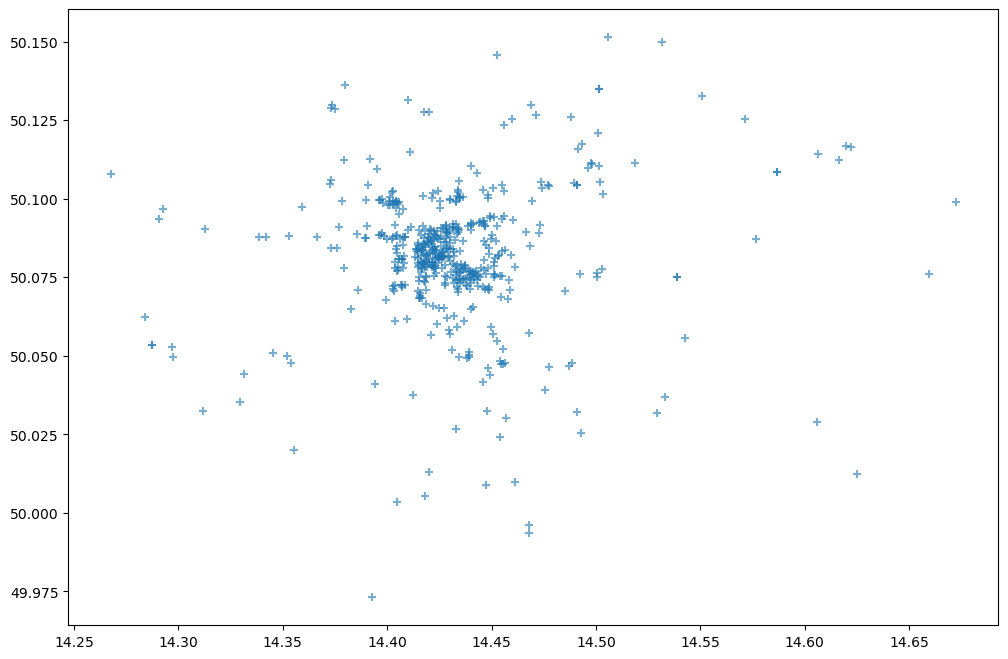

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8)) # nastavime rozumnou velikost obrazku
plt.scatter(kavarny['lng'], kavarny['lat'], alpha=0.6, marker='+', s=40)
plt.show()

It is much better to put the points on a map. We will use the `cartopy` library and a map from openstreet maps. The documentation for the library is at http://scitools.org.uk/cartopy/docs/latest/index.html.

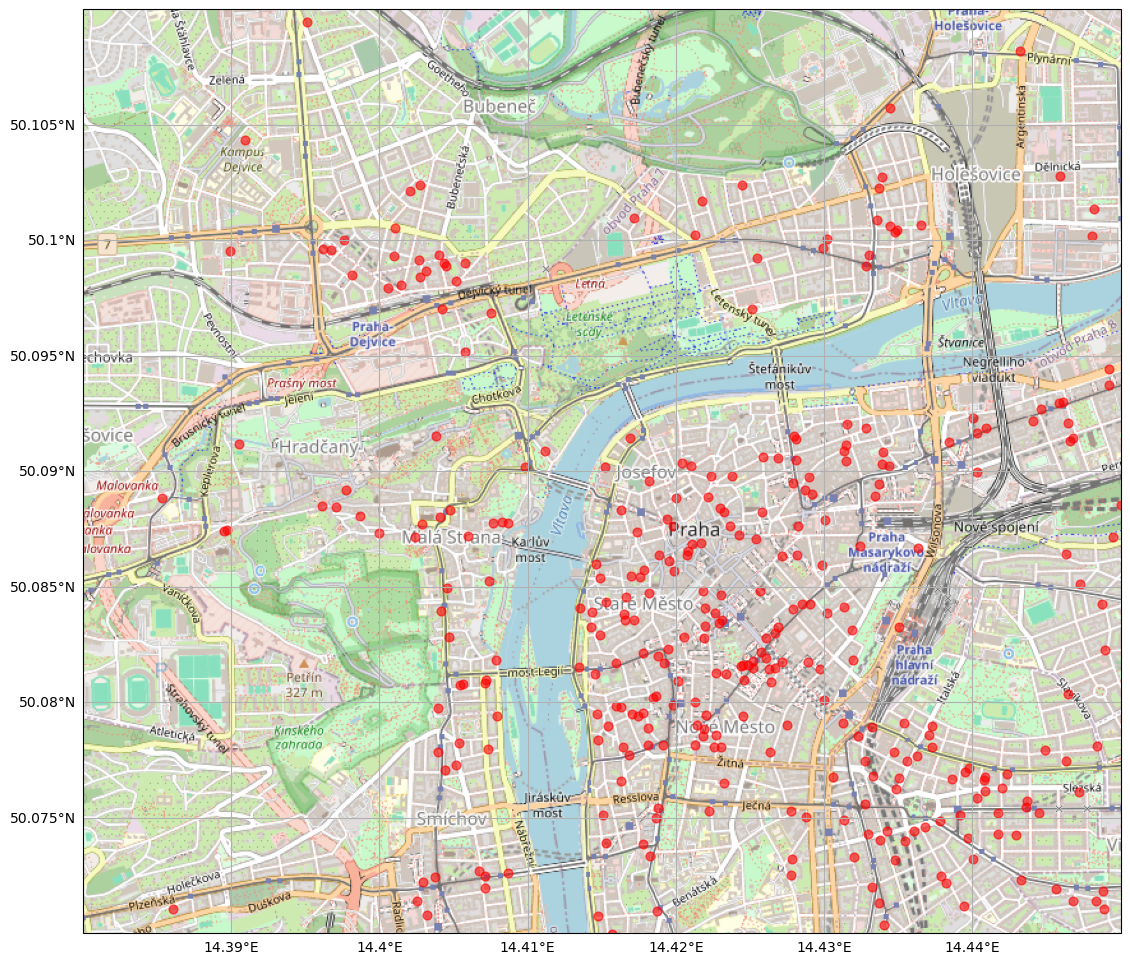

In [6]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimg
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

MIN_LNG = 14.38
MAX_LNG = 14.45
MIN_LAT = 50.07
MAX_LAT = 50.11

def make_map(figsize=(16, 12), projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

extent = [MIN_LNG, MAX_LNG, MIN_LAT, MAX_LAT]

request = cimg.OSM()
fig, ax = make_map(figsize=(16,12), projection=request.crs)
ax.set_extent(extent)

ax.add_image(request, 14) # 14 is the zoom level, greater numbers have more details (and take longer to download)
ax.scatter(kavarny['lng'], kavarny['lat'], transform=ccrs.PlateCarree(), alpha=0.6, s=40, c='red')
plt.show()

In addition to plotting cafes on the map, we might be interested to see where in Prague is the highest density of cafes. There are several ways to approach this, here we will show a procedure that assumes that the positions of cafes are generated from a mixture of Gaussian distributions and then plot the density of this mixture on the map. The disadvantage of this way of showing is that you need to tweak the parameters so that the picture looks nice and furthermore the training of the models is not deterministic and the pictures can vary after overtraining.

Another option could be to calculate the number of cafes around each point on the map and color the map accordingly, or to calculate the average distance to several nearest cafes.

C:\Users\marti\anaconda3\envs\apci\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\marti\anaconda3\envs\apci\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\marti\anaconda3\envs\apci\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


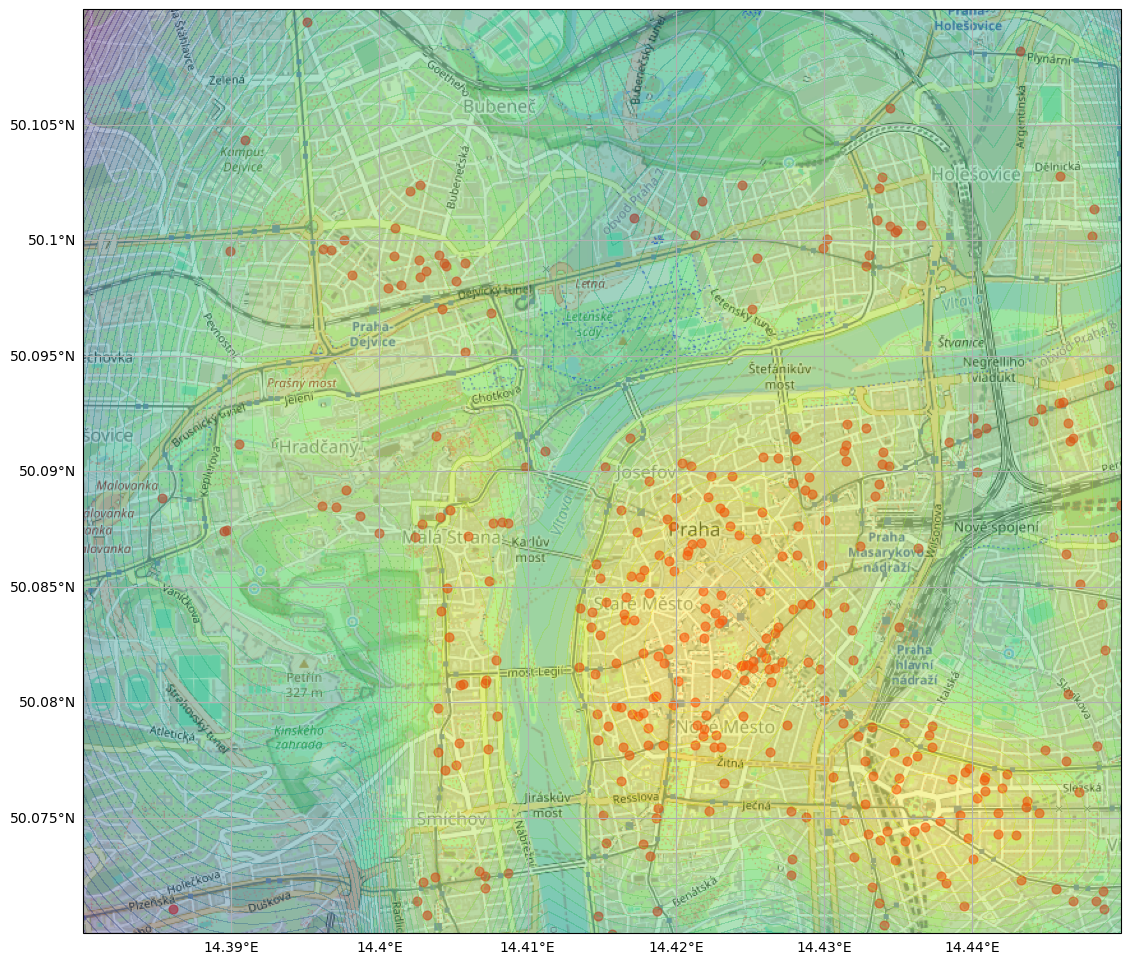

In [7]:
from sklearn import mixture
import numpy as np

filt = kavarny[kavarny.lng.between(MIN_LNG,MAX_LNG)&kavarny.lat.between(MIN_LAT, MAX_LAT)] # vyfiltrujeme jen kavarny, ktere
                                                                                           # jsou videt na mape

X_train = np.array(list(zip(filt['lng'], filt['lat']))) # vytovorime trenovaci mnozinu ze souradnic kavaren

# natrenujeme GMM (Gaussian Mixture Model) models peti komponentami
clf = mixture.GaussianMixture(n_components=6, covariance_type='full')
clf.fit(X_train)

# a zobrazime vystup modelu na mape
x = np.linspace(MIN_LNG, MAX_LNG)
y = np.linspace(MIN_LAT, MAX_LAT)
X, Y = np.meshgrid(x, y) # vytvorime si usporadane dvojice x a y souradnic
XX = np.array([X.ravel(), Y.ravel()]).T 
Z = clf.score_samples(XX) # vyhodnotime model v techto bodech
Z = Z.reshape(X.shape)

request = cimg.OSM() # zase pouzijeme OSM mapy
fig, ax = make_map(figsize=(16,12), projection=request.crs)
ax.set_extent(extent)

ax.add_image(request, 14)
ax.scatter(kavarny['lng'], kavarny['lat'], transform=ccrs.PlateCarree(), alpha=0.6, s=40, c='red') # zakreslime kavarny
ax.contourf(X, Y, Z, transform=ccrs.PlateCarree(), levels=np.linspace(np.min(Z), np.max(Z)), alpha=0.4) # a jejich hustotu

plt.show()